In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Importing Libraries

In [2]:
from datetime import datetime
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")


## Data Collection

In [1]:
path = "C:\\Users\\Hemant\\Documents\\GitHub\\Machine-Learning\\Projects\\Datasets\\nba2k20-full.csv"

In [5]:
data_init = pd.read_csv(path)
data_init.head()

,full_name,rating,jersey,team,position,b_day,height,weight,salary,country,draft_year,draft_round,draft_peak,college
0,LeBron James,97,#23,Los Angeles Lakers,F,12/30/84,6-9 / 2.06,250 lbs. / 113.4 kg.,$37436858,USA,2003,1,1,NaN
1,Kawhi Leonard,97,#2,Los Angeles Clippers,F,06/29/91,6-7 / 2.01,225 lbs. / 102.1 kg.,$32742000,USA,2011,1,15,San Diego State
2,Giannis Antetokounmpo,96,#34,Milwaukee Bucks,F-G,12/06/94,6-11 / 2.11,242 lbs. / 109.8 kg.,$25842697,Greece,2013,1,15,NaN
3,Kevin Durant,96,#7,Brooklyn Nets,F,09/29/88,6-10 / 2.08,230 lbs. / 104.3 kg.,$37199000,USA,2007,1,2,Texas
4,James Harden,96,#13,Houston Rockets,G,08/26/89,6-5 / 1.96,220 lbs. / 99.8 kg.,$38199000,USA,2009,1,3,Arizona State


## Data Exploration

In [4]:
#Checking the size of the dataset 
data_init.shape

(429, 14)

In [5]:
# Data Types
data_init.dtypes

full_name      object
rating          int64
jersey         object
team           object
position       object
b_day          object
height         object
weight         object
salary         object
country        object
draft_year      int64
draft_round    object
draft_peak     object
college        object
dtype: object

From the look of it, we can make out below observations about the data:

* There are fields in the dataset that are not relevant for predicting the salary of a player, like - Full Name, Jersey.
* College - This field contains missing values that may not necessairily mean that the player is an undergrad. It may also mean a true missing information. However, we can use this column for hypothesis testing to see if the salary depends on the college 
* From the Date of birth, we can figure out the age of a player and use that for hypotheis testing. But the date format is MM/DD/YY format
* The height and weights are present in both metric systems. We will have to use any one metric system and convert this into numerical colums intead of a string
* Salary needs to be converted to Numeric
* Draft round and Draft Pick are also strings. We must change them to Integer

We can skip the EDA for now and we will first do the data cleanup and transformation


Let's get our hands dirty


In [6]:
data = data_init.copy()
data.head()

,full_name,rating,jersey,team,position,b_day,height,weight,salary,country,draft_year,draft_round,draft_peak,college
0,LeBron James,97,#23,Los Angeles Lakers,F,12/30/84,6-9 / 2.06,250 lbs. / 113.4 kg.,$37436858,USA,2003,1,1,NaN
1,Kawhi Leonard,97,#2,Los Angeles Clippers,F,06/29/91,6-7 / 2.01,225 lbs. / 102.1 kg.,$32742000,USA,2011,1,15,San Diego State
2,Giannis Antetokounmpo,96,#34,Milwaukee Bucks,F-G,12/06/94,6-11 / 2.11,242 lbs. / 109.8 kg.,$25842697,Greece,2013,1,15,NaN
3,Kevin Durant,96,#7,Brooklyn Nets,F,09/29/88,6-10 / 2.08,230 lbs. / 104.3 kg.,$37199000,USA,2007,1,2,Texas
4,James Harden,96,#13,Houston Rockets,G,08/26/89,6-5 / 1.96,220 lbs. / 99.8 kg.,$38199000,USA,2009,1,3,Arizona State


In [7]:
data["draft_round"].value_counts() # We have to replace the "Undrafted" to 0

1            257
2            105
Undrafted     67
Name: draft_round, dtype: int64

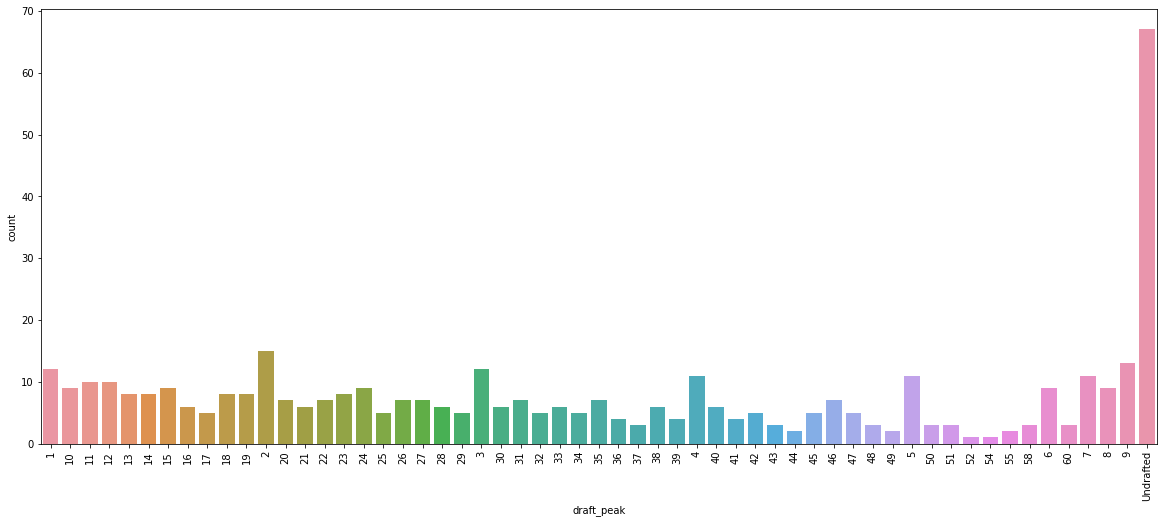

In [8]:
plt.figure(figsize = (20,8))
sns.countplot(data = data.sort_values(by = "draft_peak", ascending = True) , x = "draft_peak")
plt.xticks(rotation = 90)
# We have to replace the "Undrafted" to 0
plt.show()

In [9]:
data["college"].value_counts()

Kentucky          26
Duke              24
North Carolina    13
UCLA              12
Texas             11
                  ..
Northeastern       1
Arizona State      1
Valparaiso         1
Oklahoma State     1
TCU                1
Name: college, Length: 111, dtype: int64

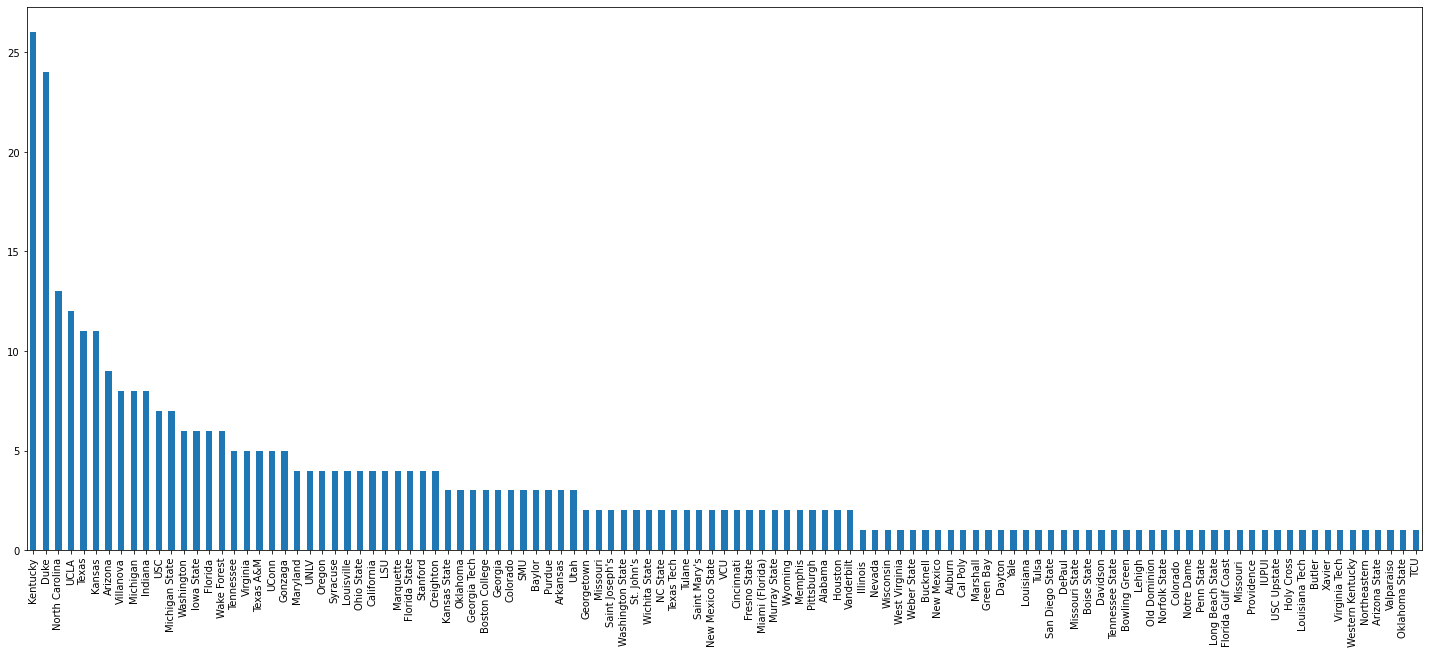

In [10]:
plt.figure(figsize = (25,10))
data["college"].value_counts(ascending = False).plot(kind = 'bar')
plt.show()

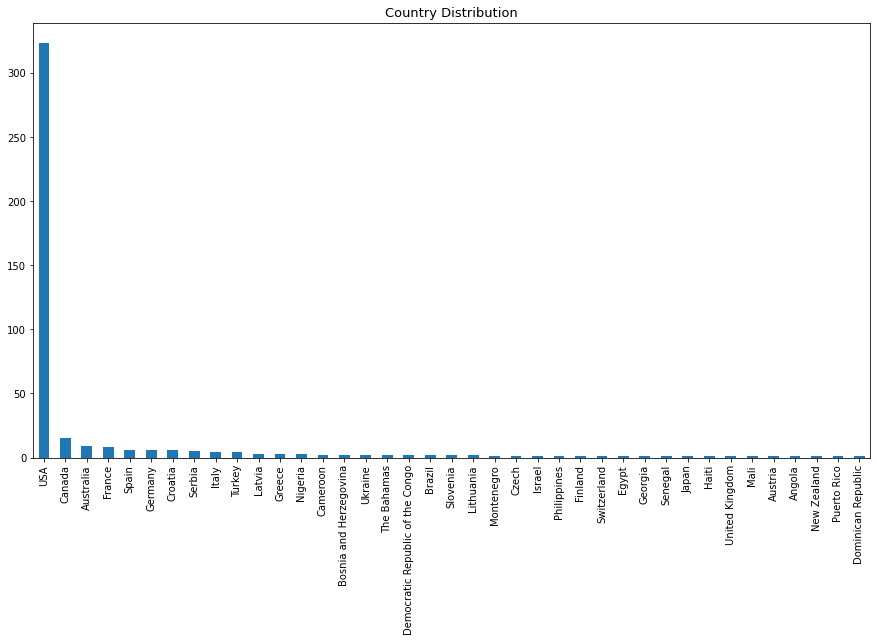

In [11]:
plt.figure(figsize = (15,8))
plt.title("Country Distribution", fontsize = 13)
data["country"].value_counts(ascending = False).plot(kind = 'bar')
plt.show()

## Data Cleaning and Transformation

In [12]:
data["draft_round"].value_counts()

1            257
2            105
Undrafted     67
Name: draft_round, dtype: int64

In [13]:
def weight_to_kg(col):
    start = col.find("/")+1
    end = col.find("kg")
    return float(col[start:end])

def height_to_mts(col):
    start = col.find("/")+1
    end = len(col)
    return float(col[start:end])


In [14]:
# Transformer
cols_to_drop = ["full_name", "jersey", "height", "weight", "draft_peak", "salary", "b_day", "draft_year"]
class Attribs_transformer(BaseEstimator, TransformerMixin):
    def __init__(self, add_bmi = True):
        self.add_bmi = add_bmi
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        X["weight_in_kg"] = X["weight"].transform(lambda x: weight_to_kg(x))
        X["height_in_mts"] = X["height"].transform(lambda x: height_to_mts(x))
        X["salary_amount"] = X["salary"].transform(lambda x: float(x[1:]))
        X["draft_round"] = X["draft_round"].transform([lambda x: 0 if x == "Undrafted" else x]).astype(int)
        X["draft_pick"] = X["draft_peak"].transform([lambda x: 0 if x == "Undrafted" else x]).astype(int)
        X["age"] = X["b_day"].transform(lambda x: relativedelta(datetime.today(),parse(x)).years)
        X["years_from_draft_year"] = X["draft_year"].transform(lambda x: datetime.today().year - x)
        if self.add_bmi:
            X["bmi"] = X["weight_in_kg"] / X["height_in_mts"]**2
        #X.drop(cols_to_drop, axis = 1, inplace = True)
        return X

In [15]:
columns_transformer = Attribs_transformer()
data_transformed = columns_transformer.transform(data)
data_transformed.head()

,full_name,rating,jersey,team,position,b_day,height,weight,salary,country,...,draft_round,draft_peak,college,weight_in_kg,height_in_mts,salary_amount,draft_pick,age,years_from_draft_year,bmi
0,LeBron James,97,#23,Los Angeles Lakers,F,12/30/84,6-9 / 2.06,250 lbs. / 113.4 kg.,$37436858,USA,...,1,1,NaN,113.4,2.06,37436858.0,1,36,18,26.722594
1,Kawhi Leonard,97,#2,Los Angeles Clippers,F,06/29/91,6-7 / 2.01,225 lbs. / 102.1 kg.,$32742000,USA,...,1,15,San Diego State,102.1,2.01,32742000.0,15,30,10,25.271652
2,Giannis Antetokounmpo,96,#34,Milwaukee Bucks,F-G,12/06/94,6-11 / 2.11,242 lbs. / 109.8 kg.,$25842697,Greece,...,1,15,NaN,109.8,2.11,25842697.0,15,26,8,24.662519
3,Kevin Durant,96,#7,Brooklyn Nets,F,09/29/88,6-10 / 2.08,230 lbs. / 104.3 kg.,$37199000,USA,...,1,2,Texas,104.3,2.08,37199000.0,2,32,14,24.107803
4,James Harden,96,#13,Houston Rockets,G,08/26/89,6-5 / 1.96,220 lbs. / 99.8 kg.,$38199000,USA,...,1,3,Arizona State,99.8,1.96,38199000.0,3,31,12,25.978759


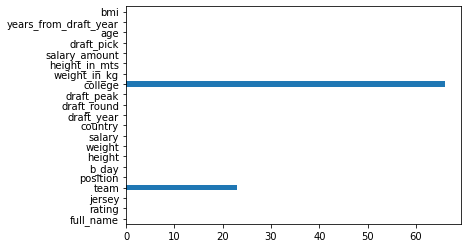

In [16]:
#Checking for Missing Values
data_transformed.isna().sum().plot(kind = 'barh')
plt.show()

The fields "college" and "team" has missing values. We willl later impute this using KNNImputer

## Hypothesis:
* Do younger players earn more?
* Which college has a good earning probability?
* Players of which country earn the most?
* Does rating decide the Salary?
* How does the Draft Pick is associated with Salary?
* Do tall players earn more salary?
* What is the height to weight ratio of players is a good indicator of salary?

In all the above hypothesis, we will check for the median salary, to avoid effects of outliers

In [17]:
df = data_transformed.copy() 

### Do younger players earn more?

[]

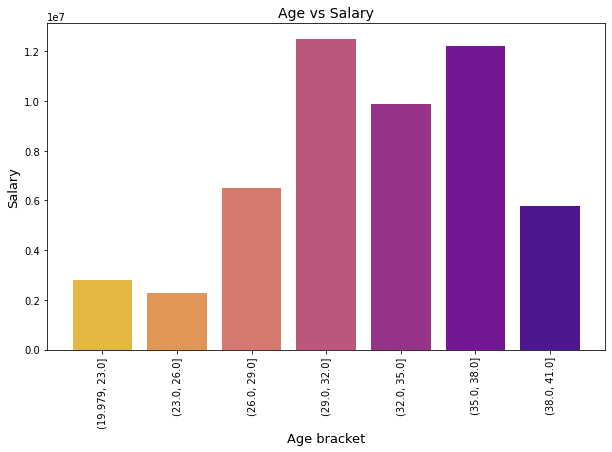

In [18]:
df_sal_by_age = df["salary_amount"].groupby(pd.cut(df["age"], bins = 7)).median().reset_index()
plt.figure(figsize = (10,6))
sns.barplot(data = df_sal_by_age, x = "age", y = "salary_amount", palette = 'plasma_r')
plt.xticks(rotation  = 90)
plt.xlabel("Age bracket", fontsize = 13)
plt.ylabel("Salary", fontsize = 13)
plt.title("Age vs Salary", fontsize = 14)
plt.plot()

Players between 35 to 38 years have a higher probability of earning more than the others, probably beacause of the experience of the game.

### Which college has a good earning probability?

[]

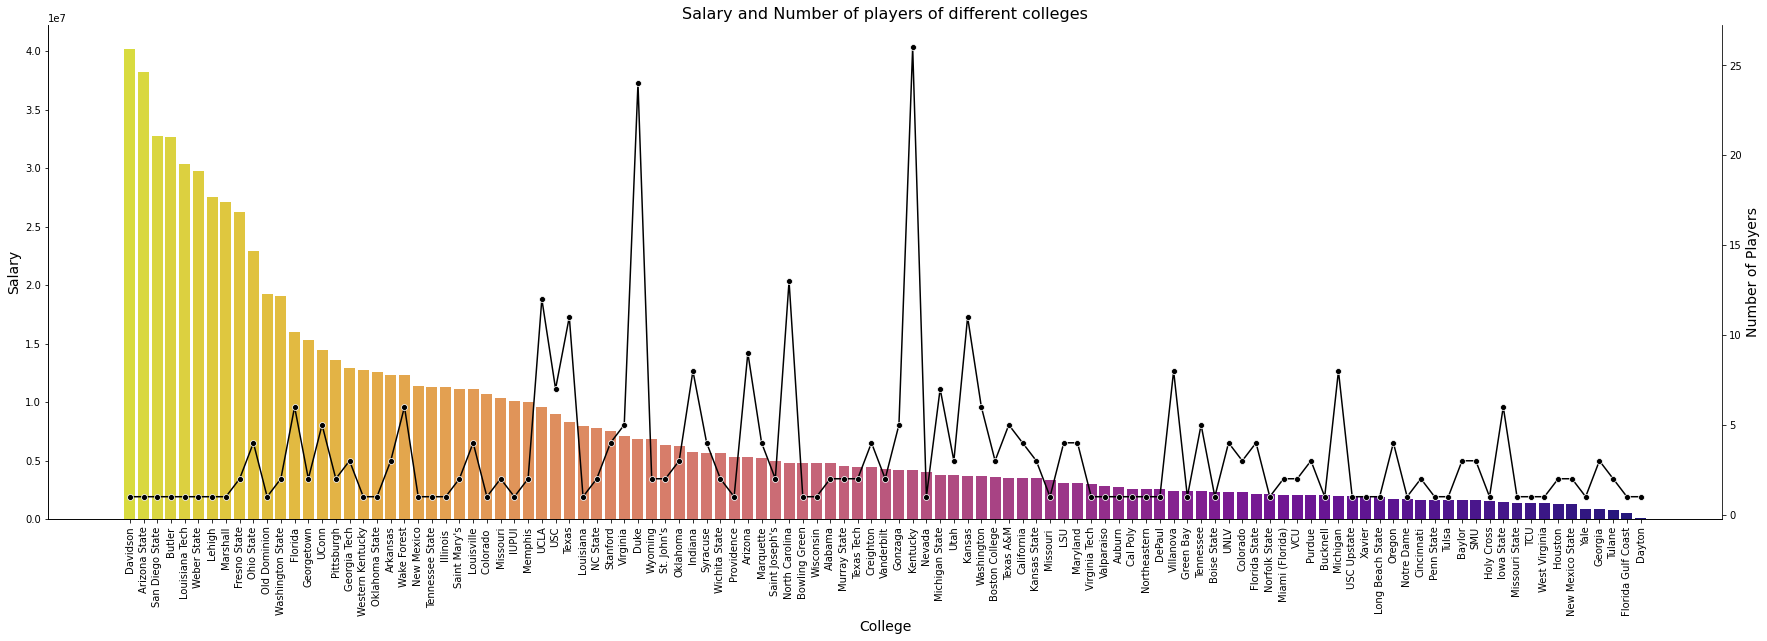

In [19]:
df_sal_by_college = df[["salary_amount", "college"]].groupby("college").agg({"salary_amount": ["median", "size"]}).reset_index()
df_sal_by_college.columns = ["college", "mean_salary", "number_players"]
plt.figure(figsize = (30,20))
ax1 = plt.subplot(2,1,1)
sns.barplot(data = df_sal_by_college.sort_values(by = "mean_salary", ascending = False), x = "college", y = "mean_salary", palette = 'plasma_r')
plt.xticks(rotation  = 90)
plt.xlabel("College", fontsize = 14)
plt.ylabel("Salary", fontsize = 14)
plt.title("Salary and Number of players of different colleges", fontsize = 16)
ax1.spines[['top','right']].set_visible(False)
plt.plot()
ax2 = ax1.twinx()
sns.lineplot(data = df_sal_by_college.sort_values(by = "mean_salary", ascending = False), x = "college", y = "number_players", palette = 'plasma_r', color = 'black', marker = "o")
plt.xticks(rotation  = 90)
plt.xlabel("College", fontsize = 14)
plt.ylabel("Number of Players", fontsize = 14)
ax2.spines['top'].set_visible(False)
plt.plot()

Even though Kentucky and Duke has almost 25 players each, the top earner is from Davidson college and with the 2nd highest salary from Arizona State.
There is only one player from each college in top 8 salaries.

The college does not contribute to salary, even though there are so many players.

## Which team offers better salaries?

In [20]:
df[["salary_amount", "team", "country"]].groupby(["team", "country"]).agg({"salary_amount": ["median", "size"]}).reset_index()

team      country salary_amount     
                                            median size
0         Atlanta Hawks       Angola     1400000.0    1
1         Atlanta Hawks        Haiti     2338846.0    1
2         Atlanta Hawks  Switzerland    16896552.0    1
3         Atlanta Hawks          USA     2686560.0    9
4        Boston Celtics       France     2505793.0    1
..                  ...          ...           ...  ...
121  Washington Wizards       France    15450051.0    1
122  Washington Wizards      Germany     1740186.0    2
123  Washington Wizards        Japan     4469160.0    1
124  Washington Wizards       Latvia     7000000.0    1
125  Washington Wizards          USA     4783860.0    8

[126 rows x 4 columns]

[]

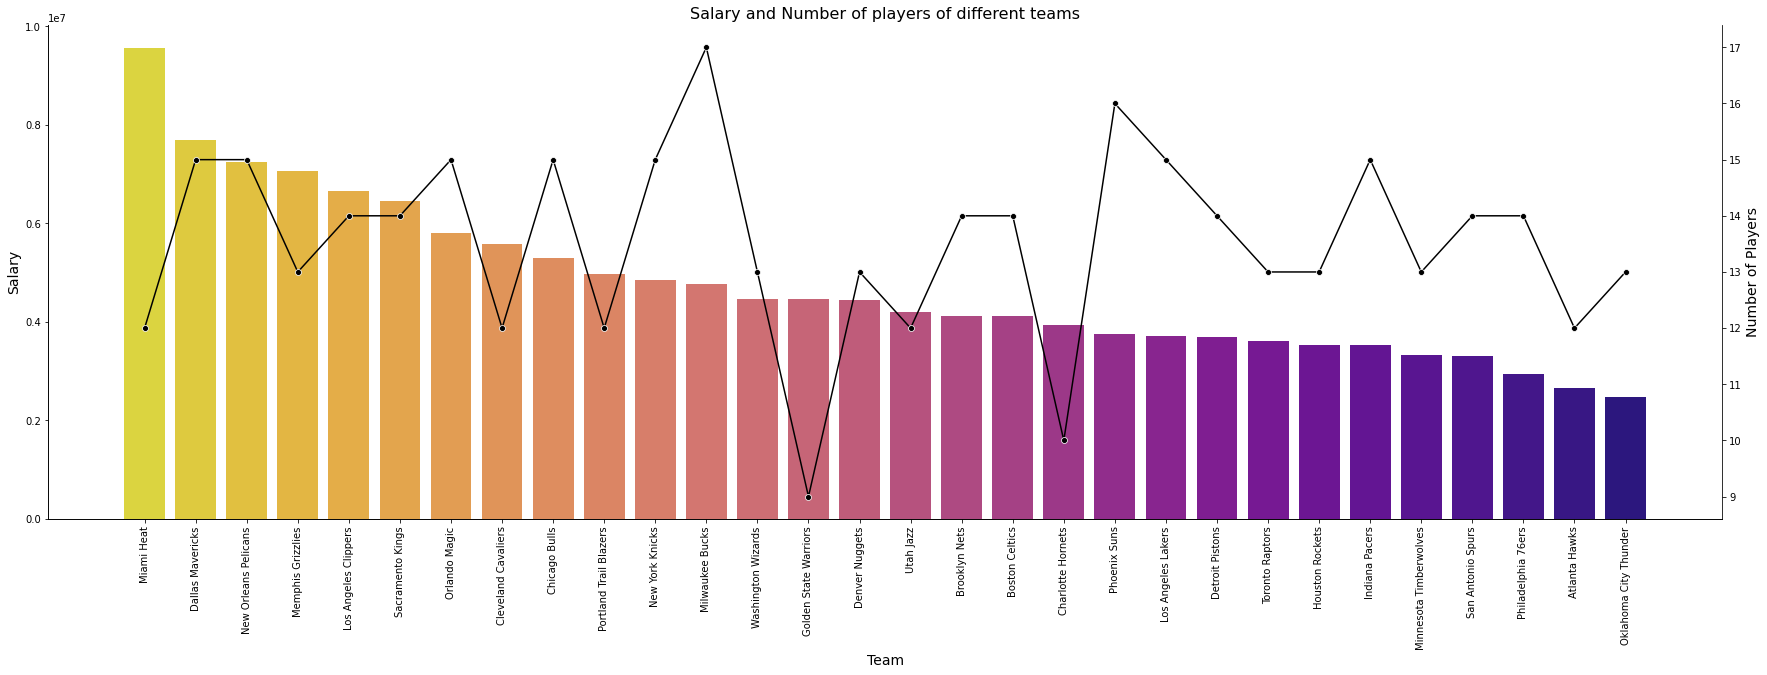

In [21]:
df_sal_by_team = df[["salary_amount", "team"]].groupby("team").agg({"salary_amount": ["median", "size"]}).reset_index()
df_sal_by_team.columns = ["team", "median_salary", "number_players"]
plt.figure(figsize = (30,20))
ax1 = plt.subplot(2,1,1)
sns.barplot(data = df_sal_by_team.sort_values(by = "median_salary", ascending = False), x = "team", y = "median_salary", palette = 'plasma_r')
plt.xticks(rotation  = 90)
plt.xlabel("Team", fontsize = 14)
plt.ylabel("Salary", fontsize = 14)
plt.title("Salary and Number of players of different teams", fontsize = 16)
ax1.spines[['top','right']].set_visible(False)
plt.plot()
ax2 = ax1.twinx()
sns.lineplot(data = df_sal_by_team.sort_values(by = "median_salary", ascending = False), x = "team", y = "number_players", palette = 'plasma_r', color = 'black', marker = "o")
plt.xticks(rotation  = 90)
plt.xlabel("Team", fontsize = 14)
plt.ylabel("Number of Players", fontsize = 14)
ax2.spines['top'].set_visible(False)
plt.plot()

The Miami Heat team offers maximum salary to its players. 

### Players of which country earn the most?

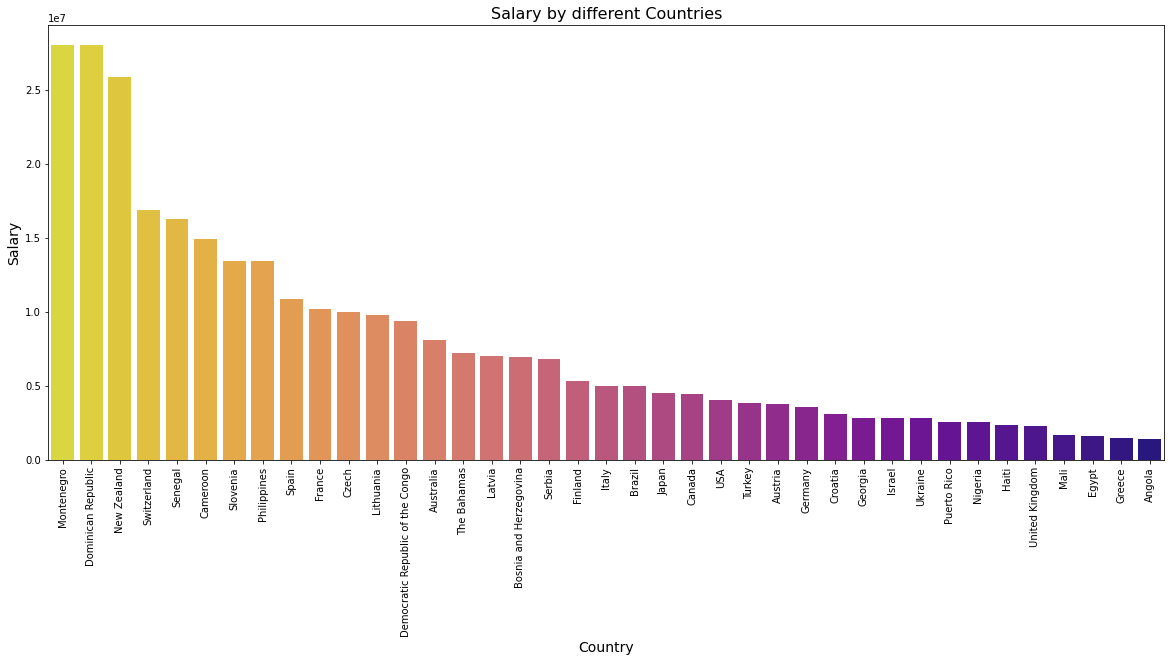

In [22]:
df_sal_by_country = df[["salary_amount", "country"]].groupby("country").median().reset_index()
plt.figure(figsize = (20,8))
#ax1 = plt.subplot(2,1,1)
sns.barplot(data = df_sal_by_country.sort_values(by = "salary_amount", ascending = False), x = "country", y = "salary_amount", palette = 'plasma_r')
plt.xticks(rotation  = 90)
plt.xlabel("Country", fontsize = 14)
plt.ylabel("Salary", fontsize = 14)
plt.title("Salary by different Countries", fontsize = 16)
plt.show()

Dominican Republic,  Montenegro  and NewZealand players earn more salary than the others. 

### Does rating decide the Salary?

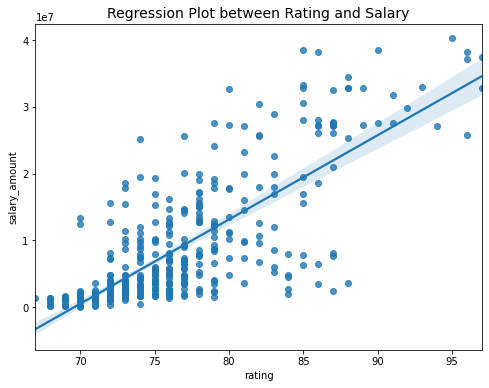

In [23]:
plt.figure(figsize = (8,6))
sns.regplot(data = df, x = "rating", y = "salary_amount")
plt.title("Regression Plot between Rating and Salary", fontsize = 14)
plt.show()

It is very evident from the regression plot that the Salary does depend on the Ratings. Higher the ratings, higer will be the salary

### Draft Pick Vs Salary

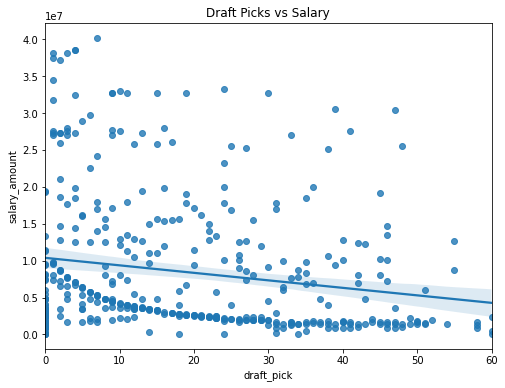

In [24]:
plt.figure(figsize = (8,6))
ax = sns.regplot(x = df["draft_pick"], y = df["salary_amount"])
plt.title("Draft Picks vs Salary")
plt.show()

Looks like there is a relationship between thw Salary and the Draft Pick. Salary is higher for players with early picks. For the players chosen in the first 5 picks, the Salary is higher generally.

The Player who get picked on the later Picks draw less salary

### Do tall players earn more salary?

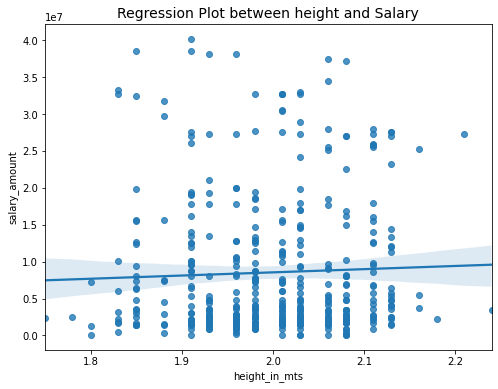

In [25]:
plt.figure(figsize = (8,6))
ax = sns.regplot(data = df, x = "height_in_mts", y = "salary_amount")
plt.title("Regression Plot between height and Salary", fontsize = 14)
plt.show()

Since the slope of the Regression line looks almost straight line parallel to X-axis, the Salary does not depend on the Height of the player.(Must be the Skill then. I wish if there was a metric present in the dataset for the skill)

### Does the BMI of a player explain the salary?

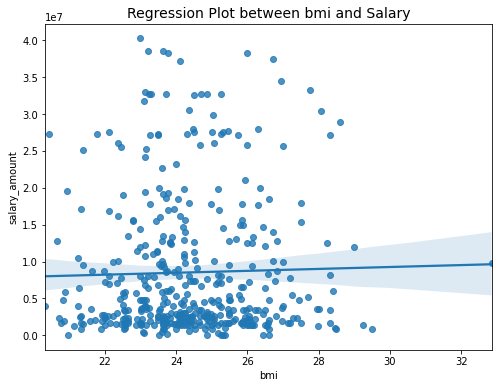

In [26]:
plt.figure(figsize = (8,6))
sns.regplot(data = df, x = "bmi", y = "salary_amount")
plt.title("Regression Plot between bmi and Salary", fontsize = 14)
plt.show()

Doesn't look like so. The slope of the regression line is parallel to BMI axis

### Checking the variation of the Salary with the numerical columns using a pair plot

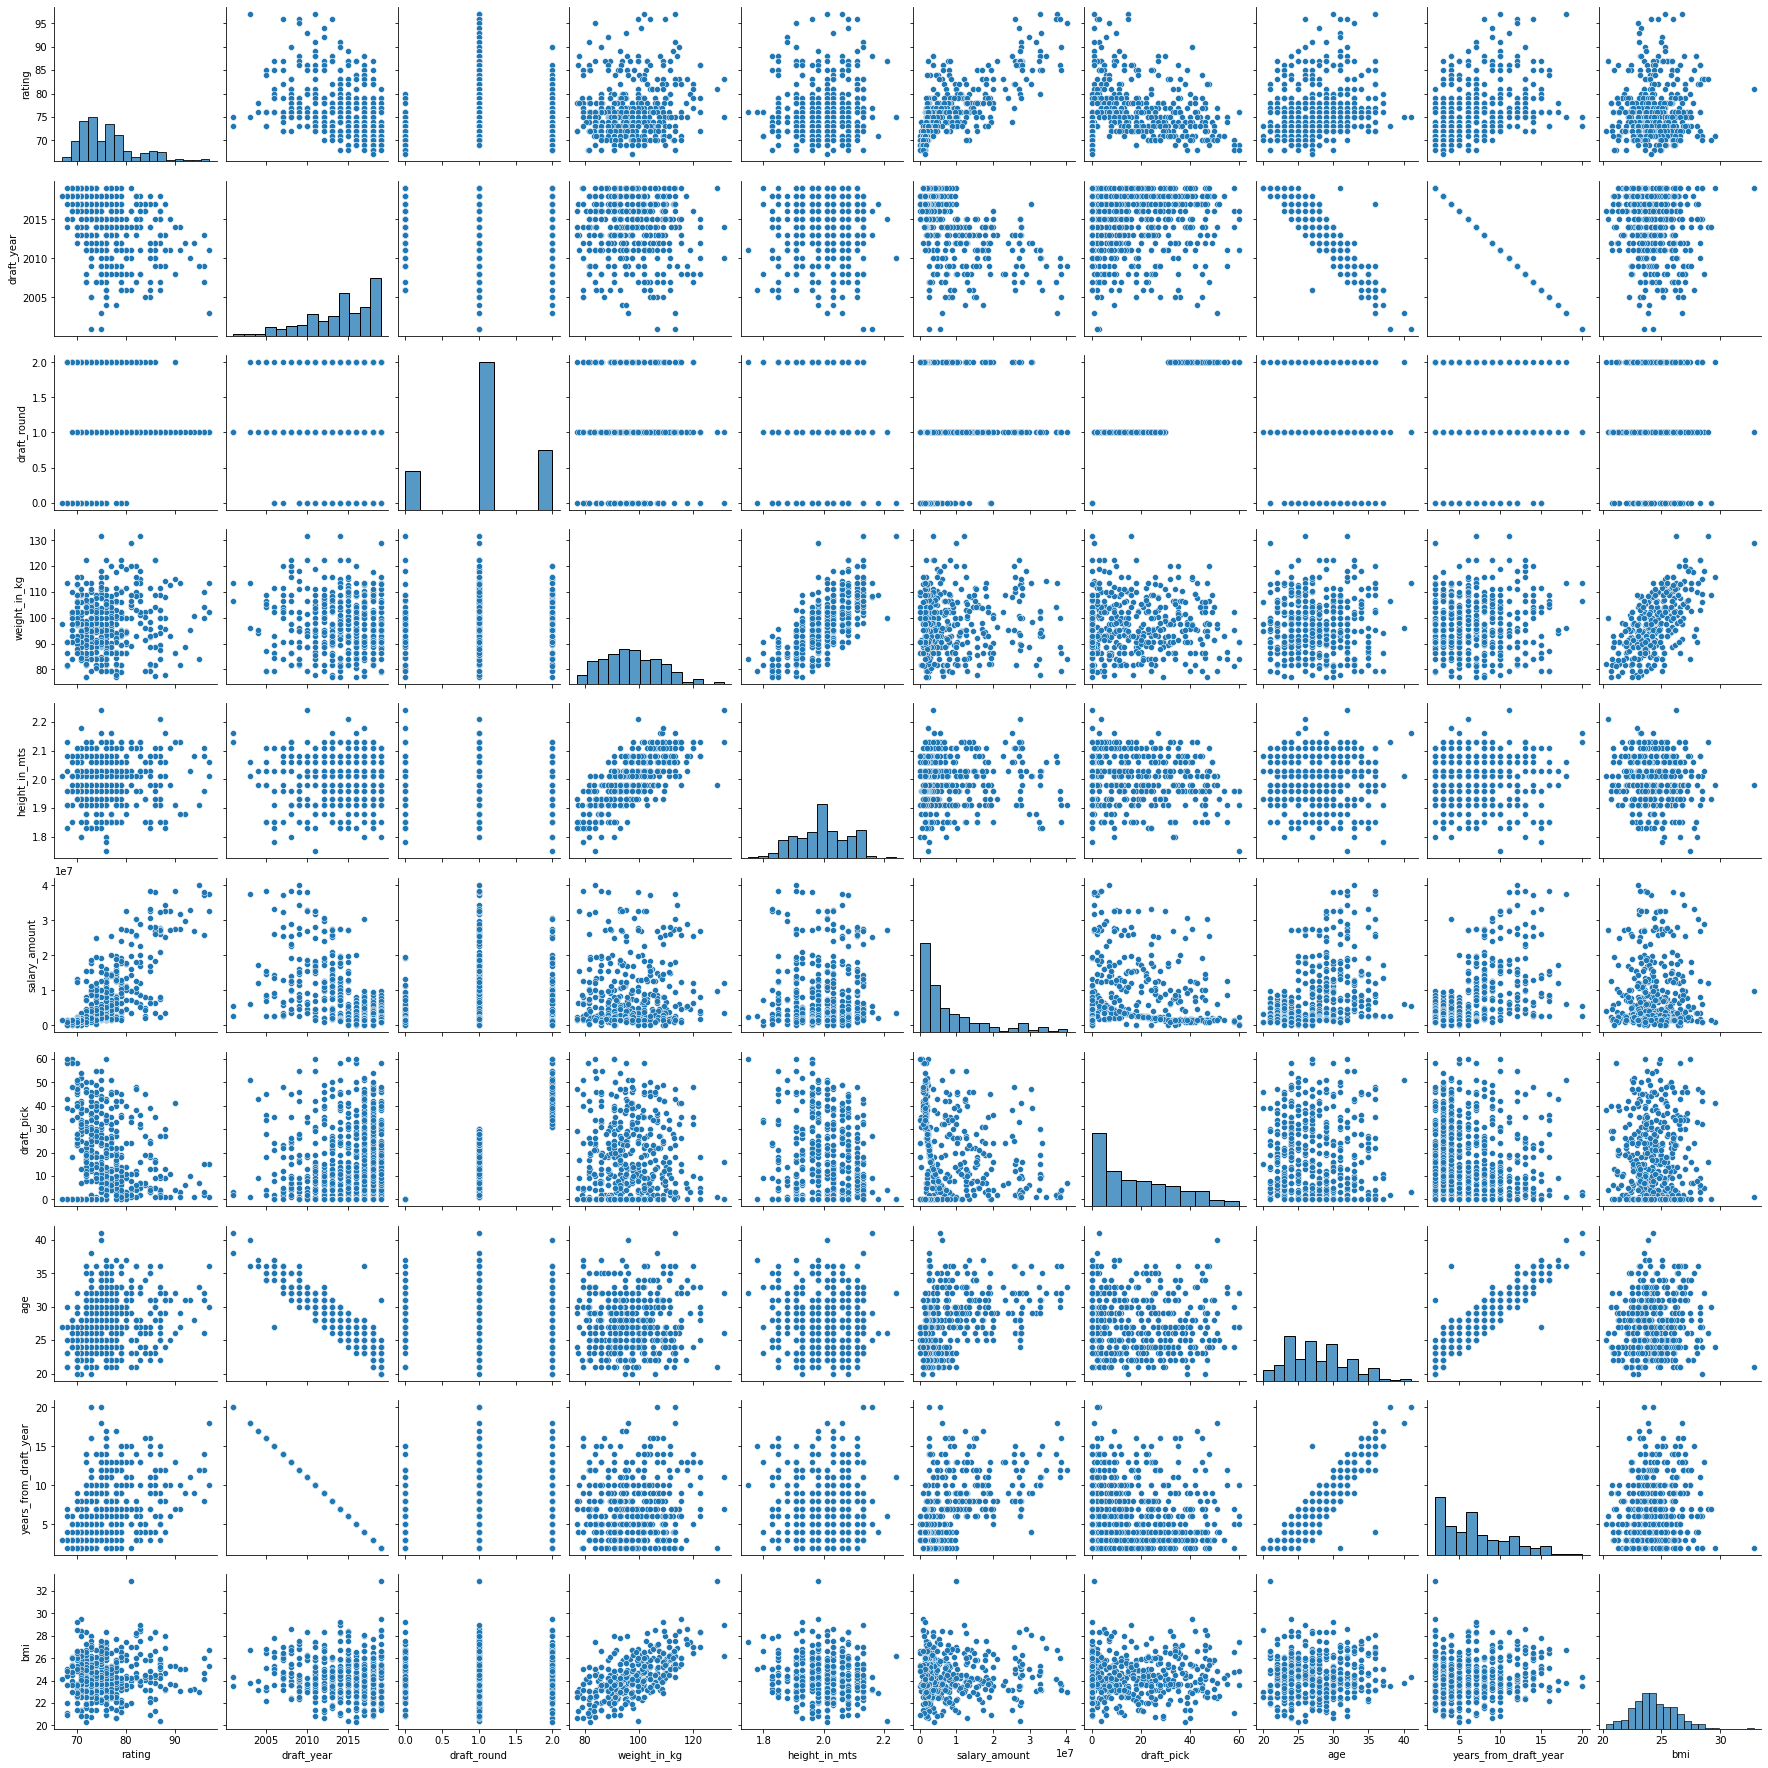

In [27]:
sns.pairplot(df)
plt.show()

**Observations**
* The Salary is linearly related with Rating. Higher the rating, better the salary.
* The Salary is linearly related with Years from Draft Year. Salary increases as the experience of player increases.
* There is also a negative relationship between Salary and Draft Pick. The graph looks lika a loarithmic curve. The Salary is higher for players with early picks. 

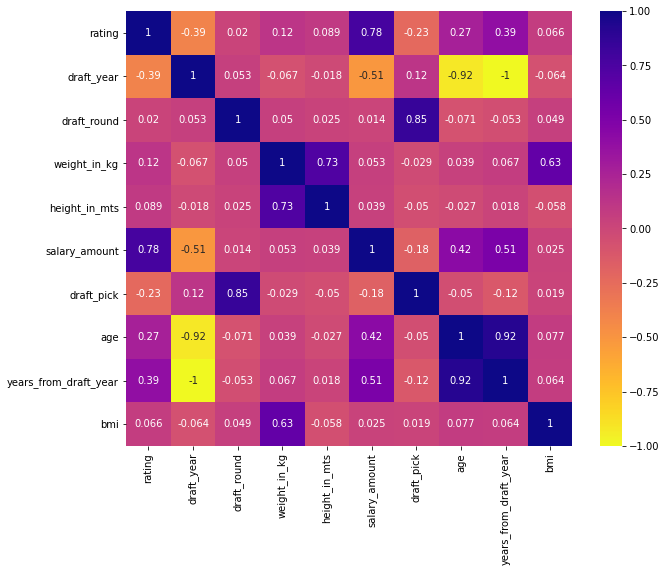

In [28]:
# Checking the Correlation coefficient
plt.figure(figsize = (10,8))
sns.heatmap(df.corr(), annot = True, cmap = 'plasma_r')
plt.show()

**The salary is highly corelated with the ratings and age. Also, the years from Draft year is correlated with the Age.**

In [29]:
cat_columns = ["team", "position", "country", "college"]

In [30]:
# Let us check the Correlation between the categories and the Salary Amount
# Team
df_cat = df[cat_columns].copy()
df_cat["salary_amount"] = df["salary_amount"].copy()
df_cat.head()
#OHE 
df_cat = pd.get_dummies(df_cat)
df_cat.head()

,salary_amount,team_Atlanta Hawks,team_Boston Celtics,team_Brooklyn Nets,team_Charlotte Hornets,team_Chicago Bulls,team_Cleveland Cavaliers,team_Dallas Mavericks,team_Denver Nuggets,team_Detroit Pistons,...,college_Washington,college_Washington State,college_Weber State,college_West Virginia,college_Western Kentucky,college_Wichita State,college_Wisconsin,college_Wyoming,college_Xavier,college_Yale
0,37436858.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,32742000.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,25842697.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,37199000.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,38199000.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


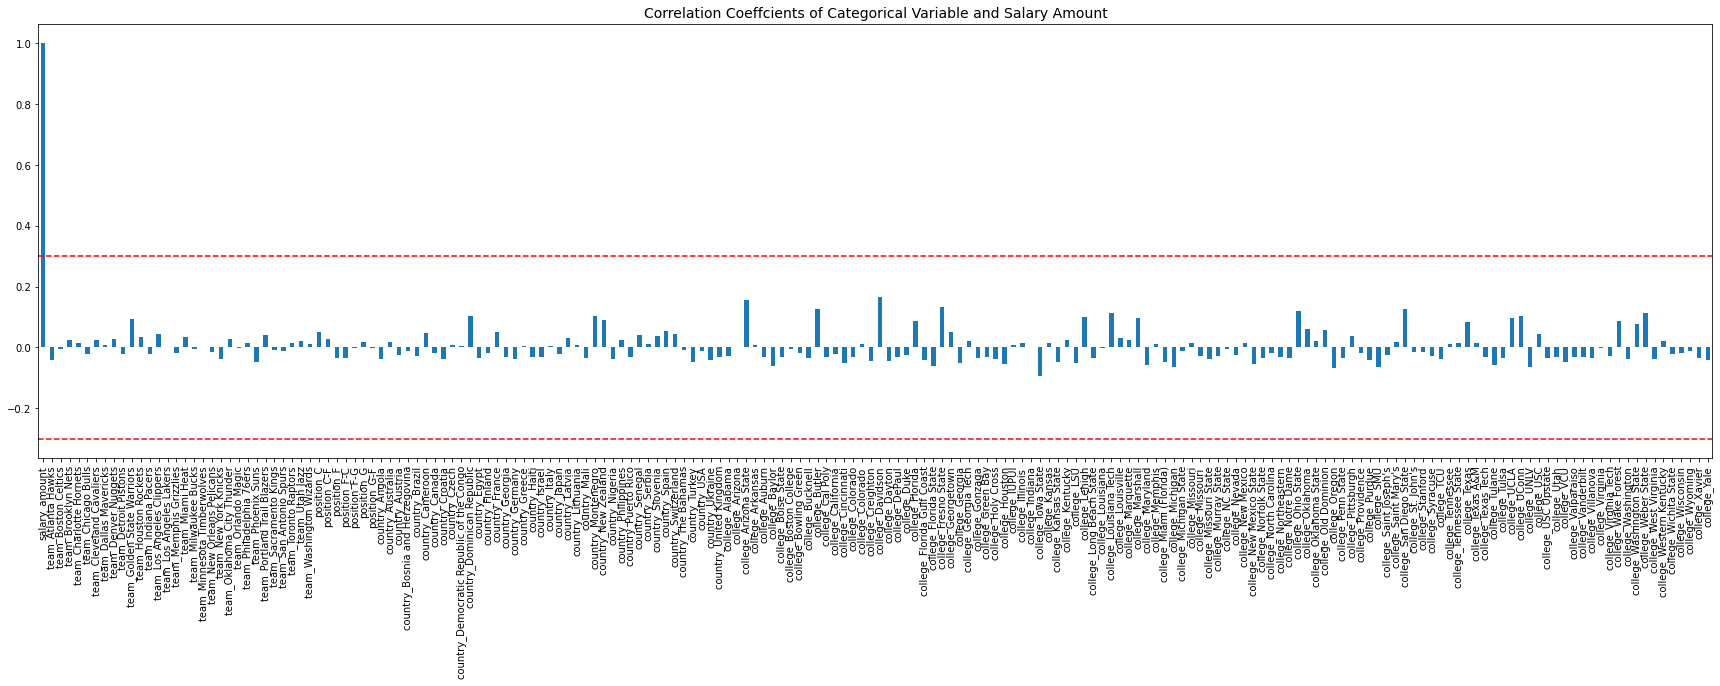

In [31]:
plt.figure(figsize = (30,8))
ax = df_cat.corr()["salary_amount"].plot(kind = 'bar')
plt.title("Correlation Coeffcients of Categorical Variable and Salary Amount", fontsize = 14)
plt.axhline(0.3, c = 'r', linestyle = '--')
plt.axhline(-0.3, c = 'r', linestyle = '--')
plt.show()

It is very evident that none of the categorical features are correlated with the target value i.e. Salary Amount. Any correlation coefficients > 0.3 or < -0.3 could be considered

## Model Creation
### Before entering the model creation phase, let us create a text dataset from the original dataset(the first DF when we collected the data). We create a test dataset and forget it for now untill we have developed a model to test on the test dataset. The data preparation pipeline will be fitted on the test dataset befroe the prediction

In [32]:
data_init.head()
# data_init.columns

,full_name,rating,jersey,team,position,b_day,height,weight,salary,country,draft_year,draft_round,draft_peak,college
0,LeBron James,97,#23,Los Angeles Lakers,F,12/30/84,6-9 / 2.06,250 lbs. / 113.4 kg.,$37436858,USA,2003,1,1,NaN
1,Kawhi Leonard,97,#2,Los Angeles Clippers,F,06/29/91,6-7 / 2.01,225 lbs. / 102.1 kg.,$32742000,USA,2011,1,15,San Diego State
2,Giannis Antetokounmpo,96,#34,Milwaukee Bucks,F-G,12/06/94,6-11 / 2.11,242 lbs. / 109.8 kg.,$25842697,Greece,2013,1,15,NaN
3,Kevin Durant,96,#7,Brooklyn Nets,F,09/29/88,6-10 / 2.08,230 lbs. / 104.3 kg.,$37199000,USA,2007,1,2,Texas
4,James Harden,96,#13,Houston Rockets,G,08/26/89,6-5 / 1.96,220 lbs. / 99.8 kg.,$38199000,USA,2009,1,3,Arizona State


In [33]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(data_init, test_size = 0.2, random_state = 1)
df_train.shape, df_test.shape

((343, 14), (86, 14))

In [34]:
df_train.isna().sum()[df_train.isna().sum()>0]

team       19
college    55
dtype: int64

## Data Preprocessing

1. Fill Missing Values
2. OHE
3. Scaling the values


In [35]:
## Importing Useful Libraries
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [36]:
df_train_transformed = Attribs_transformer().transform(df_train)
df_train_transformed

,full_name,rating,jersey,team,position,b_day,height,weight,salary,country,...,draft_round,draft_peak,college,weight_in_kg,height_in_mts,salary_amount,draft_pick,age,years_from_draft_year,bmi
46,Kyle Lowry,85,#7,Toronto Raptors,G,03/25/86,6-0 / 1.83,205 lbs. / 93 kg.,$33296296,USA,...,1,24,Villanova,93.0,1.83,33296296.0,24,35,15,27.770313
286,Dorian Finney-Smith,73,#10,Dallas Mavericks,F,05/04/93,6-7 / 2.01,213 lbs. / 96.6 kg.,$4000000,USA,...,0,Undrafted,Florida,96.6,2.01,4000000.0,0,28,5,23.910299
85,Enes Kanter,80,#11,Boston Celtics,C,05/20/92,6-10 / 2.08,262 lbs. / 118.8 kg.,$4767000,Turkey,...,1,3,NaN,118.8,2.08,4767000.0,3,29,10,27.459320
330,Thon Maker,72,#7,Detroit Pistons,F-C,02/25/97,7-0 / 2.13,216 lbs. / 98 kg.,$3569643,Australia,...,1,10,NaN,98.0,2.13,3569643.0,10,24,5,21.600652
81,Robert Covington,80,#33,Houston Rockets,F,12/14/90,6-7 / 2.01,209 lbs. / 94.8 kg.,$11301219,USA,...,0,Undrafted,Tennessee State,94.8,2.01,11301219.0,0,30,8,23.464766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,Tyler Johnson,74,#0,Brooklyn Nets,G,05/07/92,6-3 / 1.91,186 lbs. / 84.4 kg.,$19428485,USA,...,0,Undrafted,Fresno State,84.4,1.91,19428485.0,0,29,7,23.135331
72,Zion Williamson,81,#1,New Orleans Pelicans,F,07/06/00,6-6 / 1.98,284 lbs. / 128.8 kg.,$9757440,USA,...,1,1,Duke,128.8,1.98,9757440.0,1,21,2,32.853790
396,Johnathan Motley,70,#15,Los Angeles Clippers,F,05/04/95,6-8 / 2.03,230 lbs. / 104.3 kg.,$79568,USA,...,0,Undrafted,Baylor,104.3,2.03,79568.0,0,26,4,25.310005
235,Mike Scott,75,#1,Philadelphia 76ers,F,07/16/88,6-7 / 2.01,237 lbs. / 107.5 kg.,$4767000,USA,...,2,43,Virginia,107.5,2.01,4767000.0,43,33,9,26.608252


In [37]:
df_train_transformed = df_train_transformed.drop(cols_to_drop, axis = 1)
df_train_transformed

,rating,team,position,country,draft_round,college,weight_in_kg,height_in_mts,salary_amount,draft_pick,age,years_from_draft_year,bmi
46,85,Toronto Raptors,G,USA,1,Villanova,93.0,1.83,33296296.0,24,35,15,27.770313
286,73,Dallas Mavericks,F,USA,0,Florida,96.6,2.01,4000000.0,0,28,5,23.910299
85,80,Boston Celtics,C,Turkey,1,NaN,118.8,2.08,4767000.0,3,29,10,27.459320
330,72,Detroit Pistons,F-C,Australia,1,NaN,98.0,2.13,3569643.0,10,24,5,21.600652
81,80,Houston Rockets,F,USA,0,Tennessee State,94.8,2.01,11301219.0,0,30,8,23.464766
...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,74,Brooklyn Nets,G,USA,0,Fresno State,84.4,1.91,19428485.0,0,29,7,23.135331
72,81,New Orleans Pelicans,F,USA,1,Duke,128.8,1.98,9757440.0,1,21,2,32.853790
396,70,Los Angeles Clippers,F,USA,0,Baylor,104.3,2.03,79568.0,0,26,4,25.310005
235,75,Philadelphia 76ers,F,USA,2,Virginia,107.5,2.01,4767000.0,43,33,9,26.608252


In [38]:
num_cols = ["rating", "draft_round","weight_in_kg", "height_in_mts", "draft_pick", "age", "years_from_draft_year"]
cat_cols = ["team", "position", "country"]

**We will just mark the missing values as unknown**

In [39]:
df_train_transformed.fillna("Unknown", axis = 1, inplace = True)

In [40]:
X_train_df = df_train_transformed.drop("salary_amount", axis = 1)
y_train_df = df_train_transformed["salary_amount"].copy()


In [41]:
X_train_df.head()

,rating,team,position,country,draft_round,college,weight_in_kg,height_in_mts,draft_pick,age,years_from_draft_year,bmi
46,85,Toronto Raptors,G,USA,1,Villanova,93.0,1.83,24,35,15,27.770313
286,73,Dallas Mavericks,F,USA,0,Florida,96.6,2.01,0,28,5,23.910299
85,80,Boston Celtics,C,Turkey,1,Unknown,118.8,2.08,3,29,10,27.459320
330,72,Detroit Pistons,F-C,Australia,1,Unknown,98.0,2.13,10,24,5,21.600652
81,80,Houston Rockets,F,USA,0,Tennessee State,94.8,2.01,0,30,8,23.464766


In [42]:
num_pipeline = Pipeline([ 
                          #('transformer', Attribs_transformer()),
                          ('imputer', SimpleImputer(strategy = 'mean')),
                          ('scaler', StandardScaler())])

# ["rating","team", ]
# transformed = transformer_pipeline.fit_transform(df_train)
# transformed

In [43]:
ohe = OneHotEncoder(sparse = False)
ohe.fit(df_train_transformed[cat_cols])

OneHotEncoder(sparse=False)

In [44]:
total_cols_train = [*num_cols,*list(ohe.get_feature_names(cat_cols))]


In [45]:
X_train_df.head()

,rating,team,position,country,draft_round,college,weight_in_kg,height_in_mts,draft_pick,age,years_from_draft_year,bmi
46,85,Toronto Raptors,G,USA,1,Villanova,93.0,1.83,24,35,15,27.770313
286,73,Dallas Mavericks,F,USA,0,Florida,96.6,2.01,0,28,5,23.910299
85,80,Boston Celtics,C,Turkey,1,Unknown,118.8,2.08,3,29,10,27.459320
330,72,Detroit Pistons,F-C,Australia,1,Unknown,98.0,2.13,10,24,5,21.600652
81,80,Houston Rockets,F,USA,0,Tennessee State,94.8,2.01,0,30,8,23.464766


In [46]:
full_pipeline = ColumnTransformer([
                        ('num',num_pipeline, num_cols),
                        ('cat',ohe, cat_cols)
                        
], remainder = 'drop')

df_train_final  = full_pipeline.fit_transform(X_train_df)
df_train_final.shape

(343, 84)

In [47]:
df_train_final_df = pd.DataFrame(df_train_final, columns = total_cols_train) 
df_train_final_df.head()

,rating,draft_round,weight_in_kg,height_in_mts,draft_pick,age,years_from_draft_year,team_Atlanta Hawks,team_Boston Celtics,team_Brooklyn Nets,...,country_Senegal,country_Serbia,country_Slovenia,country_Spain,country_Switzerland,country_The Bahamas,country_Turkey,country_USA,country_Ukraine,country_United Kingdom
0,1.502586,-0.152119,-0.435097,-2.053808,0.343006,1.735586,1.946630,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.631522,-1.782645,-0.093656,0.132812,-1.161322,0.070727,-0.530899,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.613375,-0.152119,2.011899,0.983164,-0.973281,0.308564,0.707866,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.809364,-0.152119,0.039127,1.590559,-0.534519,-0.880621,-0.530899,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.613375,-1.782645,-0.264376,0.132812,-1.161322,0.546401,0.212360,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [48]:
## Fitting a Regression on the training dataset
X_train = df_train_final
y_train = y_train_df

In [49]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

#X_train = df_train_final_df[["rating", "draft_pick", "years_from_draft_year"]].values
#X_train = df_train_final_df[["rating", "age","draft_pick", "years_from_draft_year"]].values

X_train = df_train_final_df.values
y_train = y_train_df.values

X_train.shape, y_train.shape

((343, 84), (343,))

In [50]:
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
print("R Squared : {}".format(r2_score(y_train, y_train_pred)))

R Squared : 0.7361851142417013


In [51]:
import statsmodels.api as sm
X_train = sm.add_constant(X_train, prepend = False)
X_train

model = sm.OLS(y_train, X_train, hasconst = True)
results = model.fit()
#print(results.summary())
print(results.summary(xname = list(df_train_final_df.columns)+['constant']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     8.994
Date:                Wed, 11 Aug 2021   Prob (F-statistic):           1.40e-42
Time:                        21:36:06   Log-Likelihood:                -5763.5
No. Observations:                 343   AIC:                         1.169e+04
Df Residuals:                     261   BIC:                         1.201e+04
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [52]:
# removing "country"columns

traincols = [i for i in list(df_train_final_df.columns) if i.find("country")==-1]
X_train = df_train_final_df[traincols].values
X_train = sm.add_constant(X_train, prepend = False)

model = sm.OLS(y_train, X_train, hasconst = True)
results = model.fit()
#print(results.summary())
print(results.summary(xname = traincols + ['constant']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     16.27
Date:                Wed, 11 Aug 2021   Prob (F-statistic):           5.07e-56
Time:                        21:36:06   Log-Likelihood:                -5785.2
No. Observations:                 343   AIC:                         1.166e+04
Df Residuals:                     299   BIC:                         1.183e+04
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
rating            

In [53]:
# removing country and team columns

traincols = [i for i in list(df_train_final_df.columns) if i.find("country")==-1 and i.find("team")==-1 and i.find("position")==-1 ]
X_train = df_train_final_df[traincols].values
X_train = sm.add_constant(X_train, prepend = False)

model = sm.OLS(y_train, X_train, hasconst = True)
results = model.fit()
#print(results.summary())
print(results.summary(xname = traincols + ['constant']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     91.97
Date:                Wed, 11 Aug 2021   Prob (F-statistic):           4.03e-74
Time:                        21:36:06   Log-Likelihood:                -5808.2
No. Observations:                 343   AIC:                         1.163e+04
Df Residuals:                     335   BIC:                         1.166e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
rating                 6.591e+

In [54]:
# Considering only the coolumns with p-values < 0.05

traincols = ["age", "rating", \
             "position_F", "position_G","position_C", \
             "team_Charlotte Hornets","team_Houston Rockets","team_Los Angeles Lakers", "team_Milwaukee Bucks","team_Miami Heat","team_Golden State Warriors",\
             "country_Finland", "country_France","country_New Zealand", "country_Puerto Rico", "country_The Bahamas"]
X_train = df_train_final_df[traincols].values
X_train = sm.add_constant(X_train, prepend = False)

model = sm.OLS(y_train, X_train, hasconst = True)
results = model.fit()
#print(results.summary())
print(results.summary(xname = traincols + ['constant']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     47.10
Date:                Wed, 11 Aug 2021   Prob (F-statistic):           1.02e-74
Time:                        21:36:06   Log-Likelihood:                -5786.7
No. Observations:                 343   AIC:                         1.161e+04
Df Residuals:                     326   BIC:                         1.167e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
age                 

We are getting a good Adjusted R2 score with the set of fields with controllable values for the assumptions like, Durbin Watson test score, COnd No. score

## Checking for Assumptions of Linear Regression
0. Checking with SM
1. Linearity - Visual
2. Mean of Residuals - 
3. Check for Homoscedasticity - Durbin Watson test
4. Check for Normality of error terms/residuals
5. No autocorrelation of residuals - 
6. No perfect multicollinearity - Condition Number
 
### Linearity
* From the pair plot, we observed that the there is only linear relationship with Rating and the years from Draft Year

For the other assumptions, we have to fit the regression model first.


### 2. Mean of Residuals

In [55]:
residuals = y_train - y_train_pred
residuals.shape
print("Mean of Residuals :{}".format(residuals.mean()))

Mean of Residuals :9095.868804664724


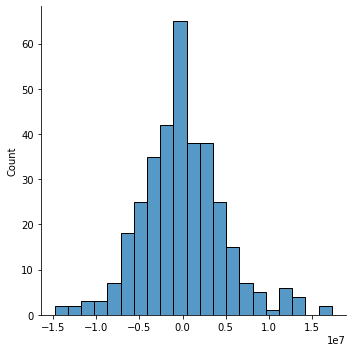

In [56]:
# Plotting the residuals
ax = sns.displot(residuals)
plt.show()

### 3. HomoScedasticity

To check for homoscedasticity, we plot the residuals for each of the predicted values. The data is homoscedastic if the model has a constant variance along the regression line.

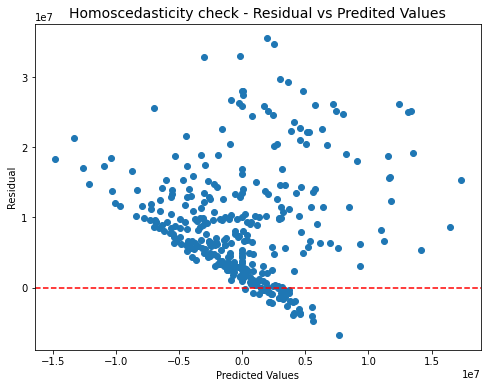

In [57]:
plt.figure(figsize = (8,6))
ax = plt.scatter(residuals, y_train_pred)
plt.xlabel("Predicted Values")
plt.ylabel("Residual")
plt.axhline(residuals.mean(), c = 'r', linestyle = '--')
plt.title("Homoscedasticity check - Residual vs Predited Values", fontsize = 14)
plt.show()

In [58]:
## Checking for homoskedasticity staistically
from statsmodels.stats.diagnostic import het_goldfeldquandt
check1 = het_goldfeldquandt(residuals, X_train)
check1

(1.085274507103424, 0.3047520201399611, 'increasing')

Since the p-value is >0.05, we can reject the nul hypothesis. Hence, there exists hetero skdeascticity in the data.

### 5. Autocorrelation in the residuals


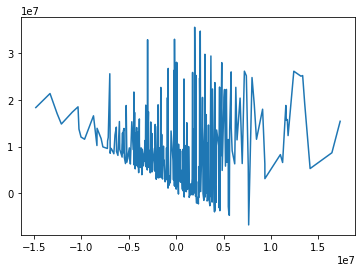

In [59]:
sns.lineplot(residuals, y_train_pred)
plt.show()

### Considering the assumptions, the Linear Regression would not be the appropriate model. We need to work with non-linear models for the regression

In [60]:
# y_train_df

In [61]:
# df_test

In [62]:
# df_test_final_df.head()

### The Baseline Regressor

In [63]:
## Linear Regression
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)

score = np.sqrt(mse)
print(f' Training MSE score :',round(score,1))
print(f' Training MAE score :',round(mae,1))

 Training MSE score : 5136753.1
 Training MAE score : 3898055.1


Since for most fields the does not vary linearly with the target variable i.e. the salary_amount, no wonder a simple linear regression will fit poorly.
Since it is underfitting the data, we will have to user a more complex model

In [64]:
# Fit Regression using Decision Tree
from sklearn.tree import DecisionTreeRegressor
dct = DecisionTreeRegressor()
dct.fit(X_train, y_train)
y_train_pred_dct = dct.predict(X_train)
print(f'MSE of Decision Tree Regressor : ', np.sqrt(mean_squared_error(y_train, y_train_pred_dct)))

MSE of Decision Tree Regressor :  1357478.2270111484


In [65]:
"""We will keep using this code to create the X_train and y_train for new models"""
X_train = df_train_final_df.values
y_train = y_train_df.values
X_train.shape, y_train.shape

((343, 84), (343,))

In [66]:
# Let us try to break the training data into Training + Validation to see how good the Decision Tree performs from Variance standpoint

X_train.shape, y_train.shape
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 10)
X_train.shape, X_val.shape
dct.fit(X_train, y_train)
y_pred_val = dct.predict(X_val)

mse = mean_squared_error(y_val, y_pred_val)
mae = mean_absolute_error(y_val, y_pred_val)

score = np.sqrt(mse)
print(f' Validation MSE score :',round(score,1))
print(f' Validation MAE score :',round(mae,1))

 Validation MSE score : 5701443.1
 Validation MAE score : 3562776.4


The baseline Decision Tree is highly overfitting the data. THe Mean error on the training data is 0 but the error on unseen data(X_val) is $7M.

In [67]:
# Feature Importances
sorted(zip(dct.feature_importances_,df_train_final_df.columns), reverse = True)

[(0.5262116198039178, 'rating'),
 (0.22264661740541328, 'years_from_draft_year'),
 (0.03707150295816014, 'weight_in_kg'),
 (0.029948215914468414, 'draft_pick'),
 (0.028177743244903294, 'draft_round'),
 (0.02638685488620983, 'team_Unknown'),
 (0.025818211579674347, 'height_in_mts'),
 (0.01440083822061636, 'age'),
 (0.012267967990969728, 'team_Milwaukee Bucks'),
 (0.01102640549677508, 'team_Sacramento Kings'),
 (0.010880178582109958, 'position_F'),
 (0.007005718126439364, 'team_Brooklyn Nets'),
 (0.005893877827257263, 'position_G'),
 (0.005424953269226457, 'country_Democratic Republic of the Congo'),
 (0.00393377914637636, 'team_Indiana Pacers'),
 (0.0035929936921952417, 'team_Houston Rockets'),
 (0.003232015160522646, 'team_New Orleans Pelicans'),
 (0.0031432294877341226, 'team_San Antonio Spurs'),
 (0.0031104424778063016, 'country_Switzerland'),
 (0.002458318939833364, 'team_Golden State Warriors'),
 (0.0022789217199570755, 'position_C'),
 (0.0021483110211786703, 'country_USA'),
 (0.00

In [68]:
## This is clearly Overfitting, but we can try to tune its hyperparamters to see if it turns out to be a not-so-strict model
features = ['rating', 'years_from_draft_year', "weight_in_kg","age", "height_in_mts", "draft_pick", 'position_F','team_Milwaukee Bucks', 'team_Sacramento Kings' ]
X_train = df_train_final_df[features].values
y_train = y_train_df.values
X_train.shape, y_train.shape


X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 10)
X_train.shape, X_val.shape

# Lets us fit a Decision Tree model to the a little less res restrictive model
#dct = DecisionTreeRegressor(max_leaf_nodes =10,min_samples_split = 50, max_depth = 5 )
dct = DecisionTreeRegressor(random_state = 10)
dct.fit(X_train, y_train)
y_pred_val_dct = dct.predict(X_val)
mse = mean_squared_error(y_val, y_pred_val_dct)
mae = mean_absolute_error(y_val, y_pred_val_dct)

score = np.sqrt(mse)
print(f' Validation MSE score for Decision Tree with Selected Features:',round(score,1))
print(f' Validation MAE score for Decision Tree with Selected Features:',round(mae,1))

 Validation MSE score for Decision Tree with Selected Features: 6195293.7
 Validation MAE score for Decision Tree with Selected Features: 4001784.5


In [69]:
""" Training and Validation for Polynomial Regression"""

from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree = 2, include_bias = False)

X_train_poly = poly_features.fit_transform(df_train_final_df[features])
y_train = y_train_df.values

X_train, X_val, y_train, y_val = train_test_split(X_train_poly, y_train, test_size = 0.2, random_state = 10)

lr.fit(X_train, y_train)

y_poly_train_pred = lr.predict(X_train)

mse = mean_squared_error(y_train, y_poly_train_pred)
mae = mean_absolute_error(y_train, y_poly_train_pred)

score = np.sqrt(mse)
print(f' Training MSE score :',round(score,1))
print(f' Training MAE score :',round(mae,1))


y_poly_val_pred = lr.predict(X_val)

mse = mean_squared_error(y_val, y_poly_val_pred)
mae = mean_absolute_error(y_val, y_poly_val_pred)

score = np.sqrt(mse)
print(f' Validation MSE score :',round(score,1))
print(f' Validation MAE score :',round(mae,1))

 Training MSE score : 4475088.3
 Training MAE score : 3288483.8
 Validation MSE score : 5438191.2
 Validation MAE score : 4142764.9


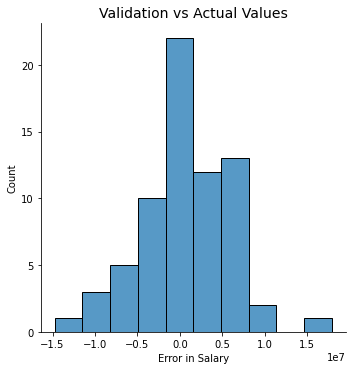

In [70]:
sns.displot(y_poly_val_pred - y_val, bins = 10)
plt.title("Validation vs Actual Values", fontsize = 14)
plt.xlabel("Error in Salary")
plt.show()

The errors are spread out. So, the model may not be a good candidate for the baseline model

In [71]:

""" Training and Validation for Decision Tree Regression"""

from sklearn.tree import DecisionTreeRegressor  

dct= DecisionTreeRegressor()

X_train = df_train_final_df[features].values
y_train = y_train_df.values

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 10)

dct.fit(X_train, y_train)

y_dct_train_pred = dct.predict(X_train)

mse = mean_squared_error(y_train, y_dct_train_pred)
mae = mean_absolute_error(y_train, y_dct_train_pred)

score = np.sqrt(mse)
print(f' Training MSE score :',round(score,1))
print(f' Training MAE score :',round(mae,1))


y_dct_val_pred = dct.predict(X_val)

mse = mean_squared_error(y_val, y_dct_val_pred)
mae = mean_absolute_error(y_val, y_dct_val_pred)

score = np.sqrt(mse)
print(f' Validation MSE score :',round(score,1))
print(f' Validation MAE score :',round(mae,1))

 Training MSE score : 0.0
 Training MAE score : 0.0
 Validation MSE score : 6498403.4
 Validation MAE score : 4152345.5


Overfitting!! - The Decision Tree Regressor has the tendecy to overfit the data most often sue to the affiliation towards the orthogonal bpundaries

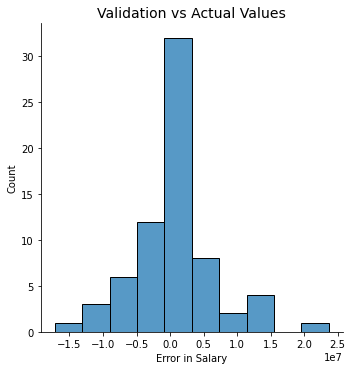

In [72]:
sns.displot(y_dct_val_pred - y_val, bins = 10)
plt.title("Validation vs Actual Values", fontsize = 14)
plt.xlabel("Error in Salary")
plt.show()

In [73]:
## Using Bagging Strategy with Linear Regression
from sklearn.ensemble import BaggingRegressor


X_train = df_train_final_df[features].values
y_train = y_train_df.values

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 10)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred_train_linreg = lin_reg.predict(X_train)
y_pred_val_linreg = lin_reg.predict(X_val)

print(f'Training MSE with Linear Regression: ', np.sqrt(mean_squared_error(y_pred_train_linreg, y_train)))
print(f'Validation MSE with Linear Regression: ', np.sqrt(mean_squared_error(y_pred_val_linreg, y_val)))
print(f'Training MAE with Linear Regression : ', mean_absolute_error(y_pred_train_linreg, y_train))
print(f'Validation MAE with Linear Regression : ', mean_absolute_error(y_pred_val_linreg, y_val))

bag = BaggingRegressor(LinearRegression(), n_estimators=500, max_samples = 0.9, bootstrap = True, n_jobs = -1)
      
bag.fit(X_train, y_train)
y_train_bag_pred = bag.predict(X_train)
y_val_bag_pred = bag.predict(X_val)

print("\n************************************************************\n")
print(f'Training MSE with Bagging: ', np.sqrt(mean_squared_error(y_train_bag_pred, y_train)))
print(f'Validation MSE with Bagging: ', np.sqrt(mean_squared_error(y_val_bag_pred, y_val)))     
print(f'Training MAE with Bagging: ',mean_absolute_error(y_pred_train_linreg, y_train))
print(f'Validation MAE with Linear Regression : ', mean_absolute_error(y_pred_val_linreg, y_val))



Training MSE with Linear Regression:  5495427.128616897
Validation MSE with Linear Regression:  5283477.4745393125
Training MAE with Linear Regression :  4036442.464147637
Validation MAE with Linear Regression :  4181374.693490291

************************************************************

Training MSE with Bagging:  5496119.405689797
Validation MSE with Bagging:  5277329.092180414
Training MAE with Bagging:  4036442.464147637
Validation MAE with Linear Regression :  4181374.693490291


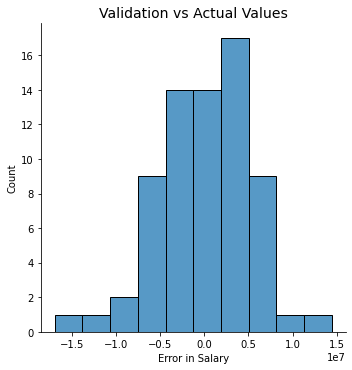

In [74]:
sns.displot(y_val_bag_pred - y_val, bins = 10)
plt.title("Validation vs Actual Values", fontsize = 14)
plt.xlabel("Error in Salary")
plt.show()

The Error terms are all over the place, so rejecting this for baseline consideration

In [75]:
## Using Bagging Strategy with Decision Tree Regression - Same as Random Forest Regressor
from sklearn.ensemble import BaggingRegressor


X_train = df_train_final_df[features].values
y_train = y_train_df.values

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 10)

dtree = DecisionTreeRegressor(random_state = 10)
dtree.fit(X_train, y_train)

y_pred_train_dtree = dtree.predict(X_train)
y_pred_val_dtree = dtree.predict(X_val)

print(f'Training MSE with Decision Tree Regression: ', np.sqrt(mean_squared_error(y_pred_train_dtree, y_train)))
print(f'Validation MSE with Decision Tree  Regression: ', np.sqrt(mean_squared_error(y_pred_val_dtree, y_val)))
print(f'Training MAE with Decision Tree : ', mean_absolute_error(y_pred_train_dtree, y_train))
print(f'Validation MAE with Decision Tree: ', mean_absolute_error(y_pred_val_dtree, y_val))

bag = BaggingRegressor(DecisionTreeRegressor(random_state = 10), n_estimators=500, max_samples = 0.9, bootstrap = True, n_jobs = -1)
      
bag.fit(X_train, y_train)
y_train_bag_pred = bag.predict(X_train)
y_val_bag_pred = bag.predict(X_val)
      
print("\n************************************************************\n")
print(f'Training MSE with Bagging: ', np.sqrt(mean_squared_error(y_train_bag_pred, y_train)))
print(f'Validation MSE with Bagging: ', np.sqrt(mean_squared_error(y_val_bag_pred, y_val))) 
print(f'Training MAE with Bagging: ', mean_absolute_error(y_train_bag_pred, y_train))
print(f'Validation MAE with Bagging: ', mean_absolute_error(y_val_bag_pred, y_val))

Training MSE with Decision Tree Regression:  0.0
Validation MSE with Decision Tree  Regression:  6195293.67993433
Training MAE with Decision Tree :  0.0
Validation MAE with Decision Tree:  4001784.492753623

************************************************************

Training MSE with Bagging:  2106136.368673012
Validation MSE with Bagging:  4788793.614100875
Training MAE with Bagging:  1382058.4388029196
Validation MAE with Bagging:  3234505.798492754


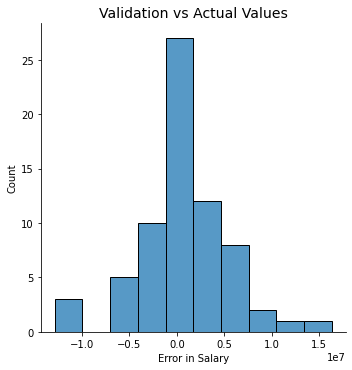

In [76]:
sns.displot(y_val_bag_pred - y_val, bins = 10)
plt.title("Validation vs Actual Values", fontsize = 14)
plt.xlabel("Error in Salary")
plt.show()

In [77]:

""" Training and Validation for Random Forest Regressor"""

from sklearn.ensemble import RandomForestRegressor  

frst= RandomForestRegressor(random_state = 10)

X_train = df_train_final_df[features].values
y_train = y_train_df.values

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 10)

frst.fit(X_train, y_train)

y_frst_train_pred = frst.predict(X_train)

mse = mean_squared_error(y_train, y_frst_train_pred)
mae = mean_absolute_error(y_train, y_frst_train_pred)

y_frst_val_pred = frst.predict(X_val)

mse = mean_squared_error(y_val, y_frst_val_pred)
mae = mean_absolute_error(y_val, y_frst_val_pred)

print(f'Training MSE with Random Forest Regression: ', np.sqrt(mean_squared_error(y_train, y_frst_train_pred)))
print(f'Validation MSE with Random Forest  Regression: ', np.sqrt(mean_squared_error(y_val, y_frst_val_pred)))
print(f'Training MAE with Random Forest  Regression : ', mean_absolute_error(y_train, y_frst_train_pred))
print(f'Validation MAE with Random Forest  Regression : ', mean_absolute_error(y_val, y_frst_val_pred))

Training MSE with Random Forest Regression:  2021362.0502468208
Validation MSE with Random Forest  Regression:  4780141.46859487
Training MAE with Random Forest  Regression :  1297112.9291970804
Validation MAE with Random Forest  Regression :  3190546.5814492754


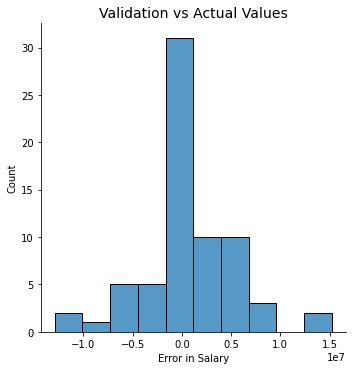

In [78]:
sns.displot(y_frst_val_pred - y_val, bins = 10)
plt.title("Validation vs Actual Values", fontsize = 14)
plt.xlabel("Error in Salary")
plt.show()

The Random Forest Regressor is consistent, meaning, the MSE in the validation is less than other models. There is scope to improve the model by hyper parameter tuning using cross validation

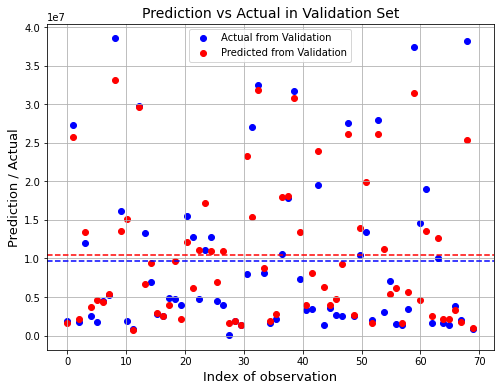

In [79]:
"""Predictions vs Actual for Random Forest"""
plt.figure(figsize = (8,6))
plt.scatter(y =y_val, x = np.linspace(0,len(y_val), len(y_val)), c = 'b', label = "Actual from Validation")
plt.scatter(y =y_frst_val_pred, x = np.linspace(0,len(y_val), len(y_val)), c = 'r', label = "Predicted from Validation" )
plt.grid(True)
plt.axhline(np.mean(y_val), c = 'b', linestyle = "--")
plt.axhline(np.mean(y_frst_val_pred), c = 'r', linestyle = "--")
plt.xlabel("Index of observation", fontsize = 13)
plt.ylabel("Prediction / Actual", fontsize = 13)
plt.legend()
plt.title("Prediction vs Actual in Validation Set", fontsize = 14)
plt.show()


In [80]:
## GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth = 1, learning_rate = 0.1, n_estimators = 150, random_state = 10)

X_train = df_train_final_df[features].values
y_train = y_train_df.values

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 10)

gbrt.fit(X_train, y_train)

y_gbrt_train_pred = gbrt.predict(X_train)

y_gbrt_val_pred = gbrt.predict(X_val)

print(f'Training MSE with GB Regression: ', np.sqrt(mean_squared_error(y_train, y_gbrt_train_pred)))
print(f'Validation MSE with GB  Regression: ', np.sqrt(mean_squared_error(y_val, y_gbrt_val_pred)))
print(f'Training MAE with GB Regression : ', mean_absolute_error(y_train, y_gbrt_train_pred))
print(f'Validation MAE with GB  Regression : ', mean_absolute_error(y_val, y_gbrt_val_pred))


Training MSE with GB Regression:  4626703.648384771
Validation MSE with GB  Regression:  4647453.454887049
Training MAE with GB Regression :  3282027.5521442783
Validation MAE with GB  Regression :  3478118.064430304


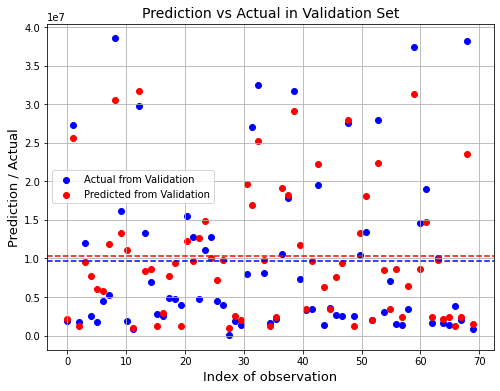

In [81]:
plt.figure(figsize = (8,6))
plt.scatter(y =y_val, x = np.linspace(0,len(y_val), len(y_val)), c = 'b', label = "Actual from Validation")
plt.scatter(y =y_gbrt_val_pred, x = np.linspace(0,len(y_val), len(y_val)), c = 'r', label = "Predicted from Validation" )
plt.grid(True)
plt.axhline(np.mean(y_val), c = 'b', linestyle = "--")
plt.axhline(np.mean(y_gbrt_val_pred), c = 'r', linestyle = "--")
plt.xlabel("Index of observation", fontsize = 13)
plt.ylabel("Prediction / Actual", fontsize = 13)
plt.legend()
plt.title("Prediction vs Actual in Validation Set", fontsize = 14)
plt.show()

## Hyperparameter Tuning 

In [82]:
from sklearn.model_selection import GridSearchCV, cross_val_score


In [83]:
param_grid = [{ "max_depth" : [1,2,4,8],
               "n_estimators" : [10,100,150,500,1000],
               "learning_rate" : [0.01, 0.1, 1.0]}
            ]

grid_search = GridSearchCV(GradientBoostingRegressor(random_state = 10), param_grid, cv = 5, scoring = "neg_mean_squared_error", n_jobs = -1, verbose = 5)

X_train = df_train_final_df[features].values
y_train = y_train_df.values

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 10)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   22.5s finished


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=10),
             n_jobs=-1,
             param_grid=[{'learning_rate': [0.01, 0.1, 1.0],
                          'max_depth': [1, 2, 4, 8],
                          'n_estimators': [10, 100, 150, 500, 1000]}],
             scoring='neg_mean_squared_error', verbose=5)

In [84]:
grid_search.best_estimator_, np.sqrt(-grid_search.best_score_)

(GradientBoostingRegressor(learning_rate=0.01, max_depth=2, n_estimators=500,
                           random_state=10),
 5021581.352677456)

In [87]:
cv_res = grid_search.cv_results_
# for (params, scores) in zip(cv_res["params"],cv_res["mean_test_score"]):
#     print("Params : " , params, " Scores : ", np.sqrt(-scores))

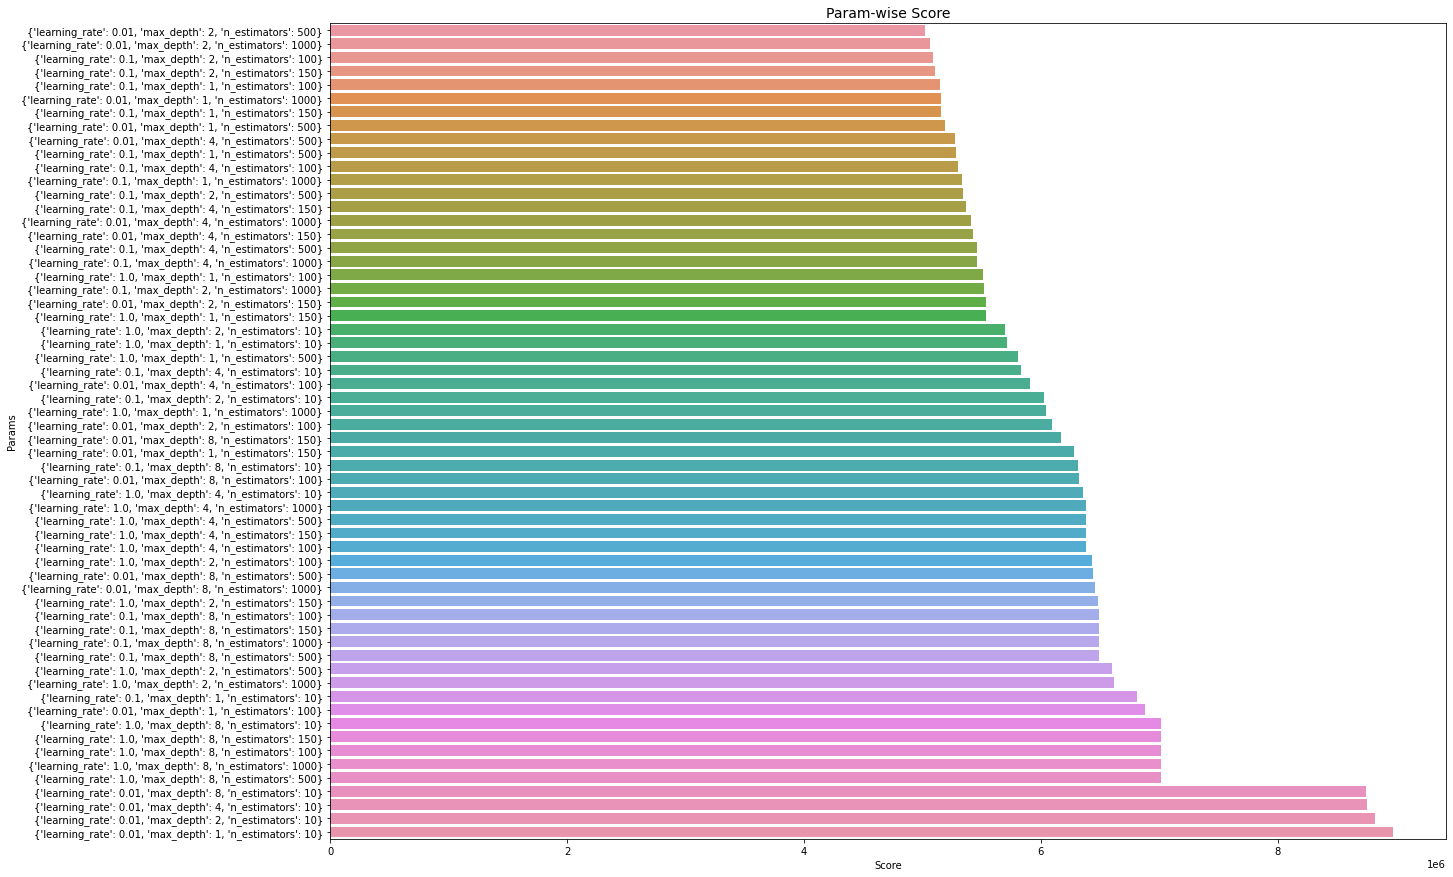

In [88]:
grid_res_df = pd.DataFrame(columns = ["Params", "Score"])
grid_res_df["Params"] = [str(i) for i in cv_res["params"]]
grid_res_df["Score"] = [np.round(np.sqrt(-i),2) for i in cv_res["mean_test_score"]]

plt.figure(figsize = (20,15))
sns.barplot(data = grid_res_df.sort_values(by = "Score", ascending = True), x = "Score", y = "Params")
plt.title("Param-wise Score", fontsize = 14)
plt.show()

In [89]:
best_model = grid_search.best_estimator_

best_model.fit(X_train, y_train)


GradientBoostingRegressor(learning_rate=0.01, max_depth=2, n_estimators=500,
                          random_state=10)

## Predicting in Test Set

In [90]:
# Preparation of X_test and Y_test
df_test_transformed = Attribs_transformer().transform(df_test)
df_test_transformed.drop(cols_to_drop, axis = 1, inplace = True)
df_test_transformed.fillna("Unknown", axis = 1, inplace = True)
ohe.fit(df_test_transformed[cat_cols])
total_test_cols = [*num_cols,*list(ohe.get_feature_names(cat_cols))]

X_test_df = df_test_transformed.drop("salary_amount", axis = 1)
y_test_df = df_test_transformed["salary_amount"].copy()

df_test_final  = full_pipeline.fit_transform(X_test_df)
df_test_final_df = pd.DataFrame(df_test_final, columns = total_test_cols) 


missing_cols = set(df_train_final_df.columns) - set(df_test_final_df)
for c in missing_cols:
    df_test_final_df[c] = 0
df_test_final_df = df_test_final_df[total_cols_train]
#df_test_final_df.head()


X_test = df_test_final_df[features].values
y_test = y_test_df.values

In [91]:
y_test_pred = best_model.predict(X_test)

print("Score in  the test set is : ", np.sqrt(mean_squared_error(y_test,  y_test_pred)))
print("R2 Score of the Test Set is : ", r2_score(y_test,  y_test_pred))

Score in  the test set is :  5088863.68326029
R2 Score of the Test Set is :  0.6345825908937177


## Generalization Error 

In [92]:
from scipy import stats
confidence = 0.95
squared_errors = (y_test - y_test_pred)**2 
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1, loc = squared_errors.mean(), scale = stats.sem(squared_errors)))

array([3095934.12561901, 6496788.36529547])

## Inference
***Given the data and its volume, the chosen model is a Gradient Boosting Regressor that has a generalization error between 3095934.12 to 6496788 with 95% confidence,
The training and prediction were done in very less volumne of data***